# $|\Delta \eta_{hh}|$ < 1.5 constraint

**Goal:** Earlier I was able to associate a part of the the low $m_{hh}$ mis-modelling with the $\Delta \eta_{hh}$ < 1.5 cut, as shown in the figure below.

So my *goal here* is to see how I can modify the R-NVP function so that I can make sure that at each transform, the abs of the difference between the two predictions stays within the region of interest.

At least for the variable transform sets that worked best in my initial pre

In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import json

import matplotlib.pyplot as plt
from matplotlib import gridspec
# This import registers the 3D projection, but is otherwise unused.
from mpl_toolkits.mplot3d import Axes3D  

from sklearn.preprocessing import StandardScaler
from scipy.stats import binned_statistic_2d, chisquare
from scipy.stats import norm 
from scipy.stats import pearsonr
from sklearn.linear_model import LinearRegression

import os
os.sys.path.append('../code')
from plotting import SR_x, SR_y1, SR_y2
from plotting import CR_x, CR_y1, CR_y2
from plotting import SB_x, SB_y1, SB_y2
from eventDisplays import rainbow_text
from termcolor import colored

os.sys.path.append('../Flow-Models')
from mdn import MixtureDensityNetwork
from densityEstimate import *
from densityPlots import *

%load_ext autoreload
%autoreload 2

Running w/ conda env: don't import root packages.


In [2]:
prodTag = 'FEB20'
ntag = 2
subDir = 'data16_PFlow-FEB20-5jets'
p = 0.01

tag = f'_SM_2b_p_{p}'
configDir = f'data16_PFlow-FEB20-5jets{tag}_2b_detaCut'
s = f'm_h1>{126-45} & m_h1<{126+45} & m_h2>{116-45} & m_h2<{116+45}'

di = data(5, 16, prodTag,tag,ntag, s)    
mi = (di.df.abs_deta_hh < 1.5)

cols = ['log_pT_h1','log_pT_h2','eta_h2','eta_h1','log_dphi_hh']
di.mlPrepare(mi, cols, N=-1)
#X_SR, Y_SR = di.X_SR, di.Y_SR

../data/data16_PFlow-FEB20-5jets/df_SM_2b_p_0.01_2b.h5
Taking 52080 events from 52080 available for the training / validation set


The $\mu$s and $\sigma$s for $\eta_{h2}$ and $\eta_{h1}$ are approximately the same, as expected.

In [9]:
di.scalar.mean_[-3:-1]

array([-0.00490815, -0.0041547 ])

In [8]:
di.scalar.scale_[-3:-1]

array([1.21901502, 1.22808439])

**Brainstorming** Michael talked about using functions like the sigmoid and tanh to enforce physical ranges, so I just wanted to try taking a look at what this meant.

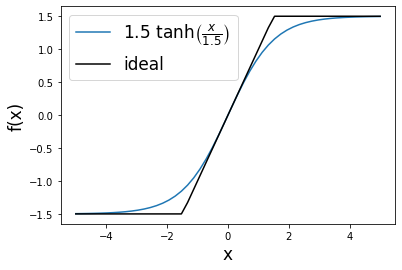

In [33]:
x = np.linspace(-5,5)
y = 1.5*np.tanh(x/1.5)
plt.plot(x,y,label=r'$1.5\ \tanh\left(\frac{x}{1.5}\right)$')

y_ideal = np.concatenate([-1.5*np.ones_like(x[x<-1.5]),
                          x[np.abs(x) < 1.5],
                          1.5*np.ones_like(x[x>1.5])])
plt.plot(x,y_ideal,'k',label='ideal')

plt.xlabel('x',fontsize=17)
plt.ylabel('f(x)',fontsize=17)
plt.legend(fontsize=17)

plt.savefig('figures/toy_plots/tanh_for_deta_cut.pdf')
plt.show()

**Message:** Although this function has the correct bounds, it's going to *soften* up the cut boundary, which seems undesirable imo.

However, if I just use the ideal function, it's *not invertible*, which is a necessary condition for each step of the flow, so I'll *have* to use an approximation if I want to impose a constraint.

If such a step makes the approximation better though, I could use maybe something that's still an ivertible function, but a better approximation? (Kind of like how spline flows stitch together a lot of invertible functions.